In [364]:
from aemeasure import read_as_pd
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
from _utils import quick_plot_setup

quick_plot_setup(use_tex=False)

In [365]:
from pcpptc import PolygonInstance, Solution
from pcpptc.plot import setup_plot, plot_polygon_instance, plot_solution
from pcpptc.plot.polgyon_instance import plot_coverage

In [366]:
read_as_pd("./solutions/2.results.json").columns

Index(['solution', 'coverage', 'touring_cost', 'length', 'turn_sum',
       'instance', 'instance_path', 'runtime', 'timestamp', 'hostname', 'argv',
       'git_revision', 'cwd', 'solver', 'i', 'turn_factor'],
      dtype='object')

In [367]:
tables = []
for f in os.listdir("./solutions"):
    if not f.endswith(".results.json"):
        continue
    f = os.path.join("./solutions", f)
    tables.append(read_as_pd(f))

data = pd.concat(tables, ignore_index=True)
data.dropna(inplace=True)

In [368]:
from pcpptc.instance_converter.dmsh import GmshGrid


def rename(s):
    names = {
        "DmshAlgorithm(DmshGrid(full_coverage=True, point_based=False, opt=CVT-full, scale=0.95, buffer=0.05, simplification=0.1, iterations=1000, hard_corners=True))": "\u25B3 dmsh(95%)",
        "DmshAlgorithm(DmshGrid(full_coverage=True, point_based=False, opt=CVT-full, scale=1.0, buffer=0.05, simplification=0.1, iterations=1000, hard_corners=True))": "\u25B3 dmsh",
        "GmshAlgorithm(GmshGrid(full_coverage=True, point_based=False, quad=False, alg=1, opt=CVT-full, scale=1.0, buffer=0.05, simplification=0.1, iterations=1000, hard_corners=True, hole_workaroundTrue))": f"\u25B3 MA",
        "GmshAlgorithm(GmshGrid(full_coverage=True, point_based=False, quad=False, alg=6, opt=CVT-full, scale=1.0, buffer=0.05, simplification=0.1, iterations=1000, hard_corners=True, hole_workaroundTrue))": f"\u25B3 FD",
        "GmshAlgorithm(GmshGrid(full_coverage=True, point_based=False, quad=False, alg=8, opt=CVT-full, scale=1.0, buffer=0.05, simplification=0.1, iterations=1000, hard_corners=True, hole_workaroundTrue))": f"\u25B3 FDQ",
        "GmshAlgorithm(GmshGrid(full_coverage=True, point_based=False, quad=False, alg=9, opt=CVT-full, scale=0.95, buffer=0.05, simplification=0.1, iterations=1000, hard_corners=True, hole_workaroundTrue))": f"\u25B3 PP(95%)",
        "GmshAlgorithm(GmshGrid(full_coverage=True, point_based=False, quad=False, alg=9, opt=CVT-full, scale=1.0, buffer=0.05, simplification=0.1, iterations=1000, hard_corners=True, hole_workaroundTrue))": f"\u25B3 PP",
        "GmshAlgorithm(GmshGrid(full_coverage=True, point_based=False, quad=True, alg=8, opt=CVT-full, scale=1.0, buffer=0.05, simplification=0.1, iterations=1000, hard_corners=True, hole_workaroundTrue))": "\u25A1 FDQ",
        "GmshAlgorithm(GmshGrid(full_coverage=True, point_based=False, quad=True, alg=9, opt=CVT-full, scale=1.0, buffer=0.05, simplification=0.1, iterations=1000, hard_corners=True, hole_workaroundTrue))": f"\u25A1 PP",
    }
    return names.get(s, s)


data["solver"] = data["solver"].apply(rename)

In [369]:
data["type"] = data["solver"].apply(lambda s: "hex" if "Hex" in s else "square")
data["point_based"] = data["solver"].apply(lambda s: "pb=True" in s)

In [370]:
instance_paths = list(data["instance_path"].unique())
instances = [PolygonInstance.from_json(file_path=f) for f in instance_paths]
instance_areas = pd.DataFrame(
    data={"area": [i.original_area.area for i in instances]}, index=instance_paths
)
data = data.merge(instance_areas, left_on="instance_path", right_index=True)

In [371]:
t_ = data.groupby("instance")[["touring_cost"]].min()
data = data.merge(t_, left_on="instance", right_index=True, suffixes=("", "_min"))
data["relative_cost"] = data["touring_cost"] / data["touring_cost_min"]
data["relative_coverage"] = data["coverage"] / data["area"]

In [372]:
instances = data["instance"].unique()
instance_data = data[data["instance"] == instances[1]]

../01_grid/instances/197.instance.json
Turn Cost: 5.0


<Figure size 432x288 with 0 Axes>

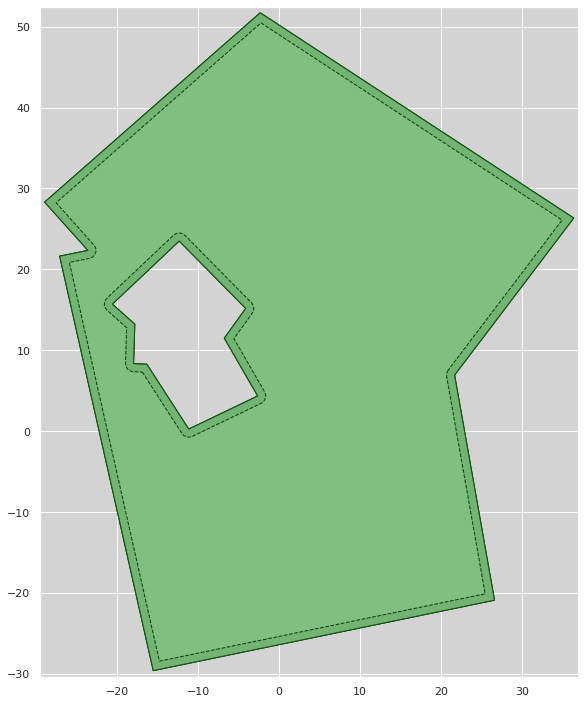

In [373]:
instance_path = instance_data.iloc[0]["instance_path"]
print(instance_path)
instance = PolygonInstance.from_json(file_path=instance_path)
print("Turn Cost:", instance.turn_cost)

ax = setup_plot(figsize=(10, 10))
plot_polygon_instance(ax, instance)
plt.show()

In [374]:
def plot(row, path=None):
    solution = Solution.from_json(data=row["solution"])
    ax = setup_plot(figsize=(4.5, 4.5))
    plot_polygon_instance(ax, instance)
    plot_solution(ax, solution)
    plot_coverage(ax, instance, solution)
    plt.title(
        f"Cost: {round(row['touring_cost'],2)}, Coverage: {round(100*row['relative_coverage'],1)}%"
    )
    plt.tight_layout()
    if path:
        plt.savefig(path)
    plt.show()

△ dmsh(95%)
Cost: 1.1244866144562526
Coverage: 0.9667956527341898
Computing coverage polygon
Plotting coverage polygon


<Figure size 432x288 with 0 Axes>

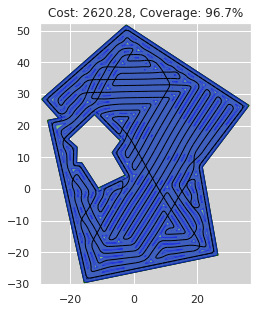

△ dmsh
Cost: 1.0484831071115357
Coverage: 0.9375284991391487
Computing coverage polygon
Plotting coverage polygon


<Figure size 432x288 with 0 Axes>

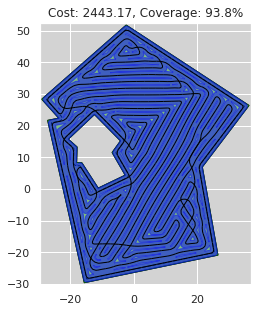

△ MA
Cost: 1.263343329595059
Coverage: 0.9872123302211996
Computing coverage polygon
Plotting coverage polygon


<Figure size 432x288 with 0 Axes>

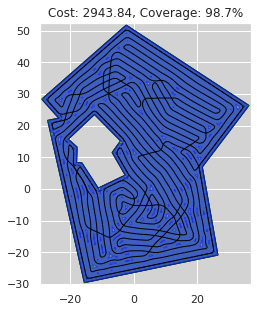

△ FD
Cost: 1.139693723783097
Coverage: 0.9873597164280952
Computing coverage polygon
Plotting coverage polygon


<Figure size 432x288 with 0 Axes>

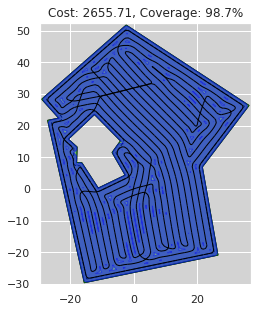

△ FDQ
Cost: 1.030586956251598
Coverage: 0.9479006786581536
Computing coverage polygon
Plotting coverage polygon


<Figure size 432x288 with 0 Axes>

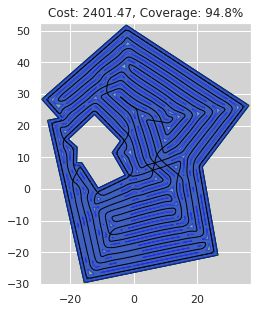

△ PP
Cost: 1.0293157725641244
Coverage: 0.9201692084465196
Computing coverage polygon
Plotting coverage polygon


<Figure size 432x288 with 0 Axes>

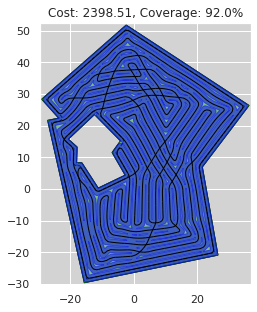

△ PP(95%)
Cost: 1.0
Coverage: 0.9356335145647633
Computing coverage polygon
Plotting coverage polygon


<Figure size 432x288 with 0 Axes>

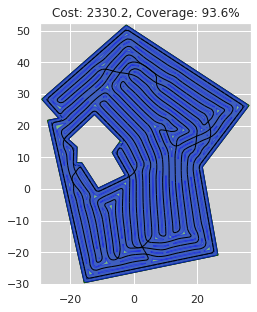

□ FDQ
Cost: 1.1931360636307455
Coverage: 0.9860646531437222
Computing coverage polygon
Plotting coverage polygon


<Figure size 432x288 with 0 Axes>

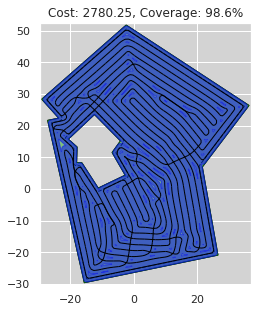

□ PP
Cost: 1.0829105944677144
Coverage: 0.9756994702743014
Computing coverage polygon
Plotting coverage polygon


<Figure size 432x288 with 0 Axes>

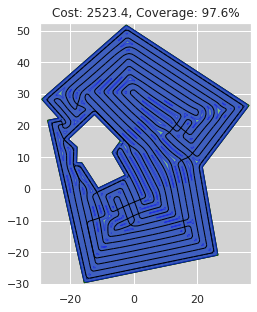

In [375]:
for i, row in instance_data.iterrows():
    print(row["solver"])
    print("Cost:", row["relative_cost"])
    print("Coverage:", row["relative_coverage"])
    plot(row, None)
    # plot( row["solution"])

# The cheapest solutions for all instance types

In [376]:
t_ = instance_data.groupby(["type", "point_based"])["touring_cost"].min()
for i, v in t_.iteritems():
    row = instance_data[
        (instance_data["type"] == i[0])
        & (instance_data["point_based"] == i[1])
        & (instance_data["touring_cost"] == v)
    ].iloc[0]
    print(row["solver"])
    print(row["touring_cost"], row["coverage"], row["length"], row["turn_sum"])

△ PP(95%)
2330.199592944471 2926.19324251487 1543.4529469512784 157.34932919863843


Text(0, 0.5, 'Meshing Algorithm')

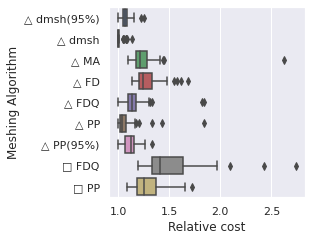

In [377]:
plt.figure(figsize=(3.5, 3.5))
sns.boxplot(data=t, y="solver", x="relative_cost", orient="h")
plt.xlabel("Relative cost")
plt.ylabel("Meshing Algorithm")

Text(0, 0.5, 'Meshing Algorithm')

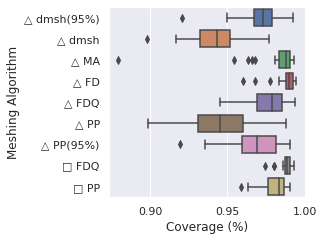

In [378]:
plt.figure(figsize=(3.5, 3.5))
sns.boxplot(data=t, y="solver", x="relative_coverage", orient="h")
plt.xlabel("Coverage (%)")
plt.ylabel("Meshing Algorithm")

In [379]:
t_ = data.dropna()
t_ = t_.groupby(["solver"])["instance"].nunique()
t_

solver
□ FDQ          30
□ PP           29
△ FD           32
△ FDQ          32
△ MA           33
△ PP           32
△ PP(95%)      30
△ dmsh         33
△ dmsh(95%)    33
Name: instance, dtype: int64

In [380]:
data.groupby(["solver"])["runtime"].mean()

solver
□ FDQ           87.029175
□ PP            70.446708
△ FD           124.098626
△ FDQ          103.919918
△ MA           120.159053
△ PP            91.657531
△ PP(95%)       80.975735
△ dmsh         108.996932
△ dmsh(95%)    123.381384
Name: runtime, dtype: float64